In [ ]:
!pip install simpletransformers
!pip install scikit-learn

In [2]:
from simpletransformers.ner import NERModel, NERArgs

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
%cd /content/gdrive/MyDrive
%cp -av best_model /content/model

/content/gdrive/MyDrive
'best_model' -> '/content/model'
'best_model/config.json' -> '/content/model/config.json'
'best_model/special_tokens_map.json' -> '/content/model/special_tokens_map.json'
'best_model/tokenizer_config.json' -> '/content/model/tokenizer_config.json'
'best_model/sentencepiece.bpe.model' -> '/content/model/sentencepiece.bpe.model'
'best_model/pytorch_model.bin' -> '/content/model/pytorch_model.bin'
'best_model/training_args.bin' -> '/content/model/training_args.bin'
'best_model/model_args.json' -> '/content/model/model_args.json'
'best_model/eval_results.txt' -> '/content/model/eval_results.txt'
'best_model/optimizer.pt' -> '/content/model/optimizer.pt'
'best_model/scheduler.pt' -> '/content/model/scheduler.pt'


In [5]:
_NER_TAGS = ['0', '1']
Threshold = 0.5
args = NERArgs()
args = {
    "threshold": Threshold
}
model = NERModel(
    model_name="/content/model",
    model_type="camembert",
    args=args
)

/usr/local/lib/python3.10/dist-packages/simpletransformers/ner/ner_model.py:433: UserWarning: use_multiprocessing automatically disabled as CamemBERT fails when using multiprocessing for feature conversion.
  warnings.warn(


In [6]:
import pandas as pd
import ast
df = pd.read_excel("/content/Final_ner_test.xlsx")
test_lst = []
# trainset
for k in df.index:
  id = df['ID'][k].replace('[','').replace(']','').split(",")
  token = df['Tokenizer'][k]
  token = ast.literal_eval(token)
  for i in range(len(id)):
    test_lst.append([k,token[i],str(int(id[i]))])
test_data = test_lst
test_data = pd.DataFrame(
    test_data, columns=["sentence_id", "words", "labels"]
)
eval_data = test_data
result, model_outputs, preds_list = model.eval_model(eval_data)

/usr/local/lib/python3.10/dist-packages/simpletransformers/ner/ner_utils.py:190: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  return [


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 1 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:159: UndefinedMetricWarning: F-s

Confusion Matrix:
[[1907   19]
 [ 101  158]]


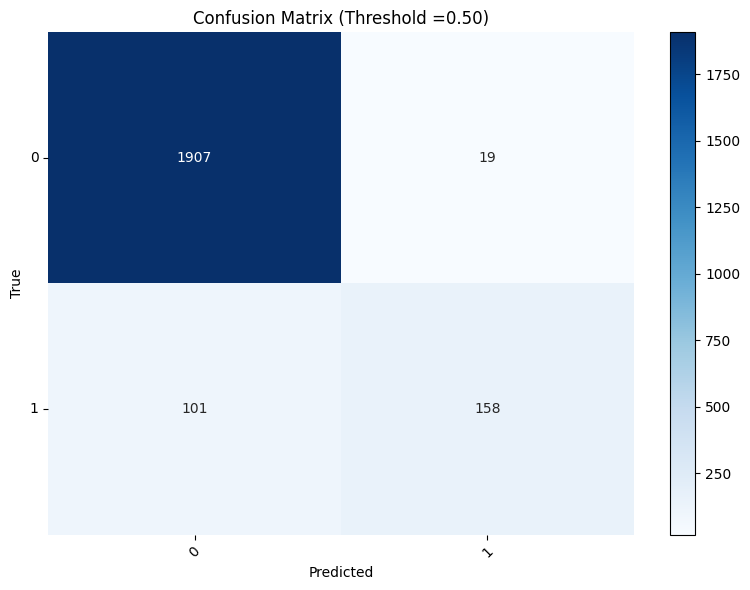

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
eval_labels = eval_data['labels']
class_names = ["0","1"]
preds_flat = [pred for preds in preds_list for pred in preds]
min_length = min(len(eval_labels), len(preds_flat))
eval_labels = eval_labels[:min_length]
preds_flat = preds_flat[:min_length]
cm = confusion_matrix(eval_labels, preds_flat)
print("Confusion Matrix:")
print(cm)
fig, ax = plt.subplots(figsize=(8, 6))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title(f'Confusion Matrix (Threshold ={Threshold:.2f})')
heatmap.set_xticklabels(class_names, rotation=45)
heatmap.set_yticklabels(class_names, rotation=0)
cbar = ax.figure.colorbar(heatmap.collections[0])
plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
labels_true = []
labels_pred = []
total = 0
for i in range(len(preds_list)):
    for k in range(len(preds_list[i])):
        labels_true.append(test_data['labels'][total])
        labels_pred.append(preds_list[i][k])
        total += 1
report = classification_report(labels_true, labels_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.drop('support', axis=1, inplace=True)
report_df.drop('accuracy', axis=0, inplace=True)
report_df.drop('macro avg', axis=0, inplace=True)
plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-1, :], annot=True, fmt='.3f', cmap='YlGnBu')
plt.title(f'Classification Report (Threshold = {Threshold:.2f})')
plt.ylabel('Metrics')
plt.xlabel('Classes')
plt.show()

In [ ]:
import pandas as pd

# eval_data = test_data
# result, model_outputs, preds_list = model.eval_model(eval_data)
correct = 0
x = 0
k = 0
wrong_prediction = []
actual_label = []
wrong_word = []

for i in range(len(preds_list)):
    for k in range(len(preds_list[i])):
        if preds_list[i][k] == test_data['labels'][x]:
            correct += 1
        else:
            wrong_prediction.append(preds_list[i][k])
            wrong_word.append(test_data['words'][x])
            actual_label.append(test_data['labels'][x])
        x += 1

print(f'len wrong-prediction: {len(wrong_prediction)}, 1: {wrong_prediction.count("1")}, 0: {wrong_prediction.count("0")}')

# Create a DataFrame with the wrong predictions, actual labels, and words
df = pd.DataFrame({'Actual Label': actual_label, 'Predicted Label': wrong_prediction, 'Word': wrong_word})
# /content/Final_ner_test.xlsx
# Save the DataFrame to a CSV file
df.to_csv('/content/Wrong_Predictions.csv', index=False, encoding='utf-8-sig')

print("CSV file 'wrong_predictions.csv' saved successfully.")


In [ ]:
from sklearn.metrics import classification_report

# eval_data = test_data
# result, model_outputs, preds_list = model.eval_model(eval_data)

labels_true = []
labels_pred = []

total = 0  # Initialize total

for i in range(len(preds_list)):
    for k in range(len(preds_list[i])):
        labels_true.append(test_data['labels'][total])
        labels_pred.append(preds_list[i][k])
        total += 1

report = classification_report(labels_true, labels_pred)
print(report)

In [ ]:
predictions, raw_outputs = model.predict(["ตู้เหล็กแบบ 2 บาน จำนวน 2 ตู้ โดยมีคุณลักษณะ ดังนี้ (1) มีมือจับชนิดผลัก (2) มีแผ่นชั้นปรับระดับ 3 ชิ้น (3) ฐานของตู้เหล็กมีความยาว 2 เมตร (4) มีระบบ noice system (5) สามารถกันนิวเคลียร์ได้ (6) มีลายกระหนก"])
print(predictions)